# Graduate Admission

Data Spaces  
Loparco Enrico - s261072

## Table of Contents
* [Introduction](#introduction)
* [Dataset Description](#dataset-description)
* [Data Acquisition](#data-acquisition)
* [Data Exploration](#data-esploration)
    + [Univariate Analysis](#univariate-analysis)
    + [Bivariate Analysis](#bivariate-analysis)
    + [Multivariate Analysis](#multivariate-analysis)
* [Train/Test Split](#split)
* [Dimensionality Reduction](#dimensionality-reduction)
    + [LDA](#lda)
    + [PCA](#pca)
* [Model Training](#model-training)
    + [Logistic Regression](#logistic-regression)
    + [KNN](#knn)
    + [SVM](#svm)
    + [Decision Tree](#decision-tree)
    + [Random Forest](#random-forest)
* [Model Evaluation](#model-evaluation)
    + [Learning Curve](#learning-curve)
    + [Confusion Matrix](#confusion-matrix)
    + [Performance Measures](#performance-measures)
    + [ROC Curve](#roc-curve)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This case study is aimed at practicing with what has been studied and explained during the Data Spaces course.  
It tries to go through the whole process of data science, starting from data acquisition, visualization and exploration to model training and evaluation.  
This notebook intends to report the results obtained, provided with comments and comparisons of the outcomes with what has been studied in the theory.  

## Dataset Description <a name="dataset-description"></a>

The dataset [Graduate Admission](https://www.kaggle.com/mohansacharya/graduate-admissions) is public and available on Kaggle.  
It was created for prediction of graduate admissions given different parameters that are considered important during the application for Master Programs:
* **GRE Scores**: out of 340, Graduate Record Examinations is a standardized test that is an admission requirement for many graduate schools in the United States and Canada;
* **TOEFL Scores**: out of 120, Test of English as a Foreign Language is a standardized test to measure the English language ability of non-native speakers wishing to enroll in English-speaking universities;
* **University Rating**: out of 5, evaluation of the university of provenance;
* **Statement of Purpose (SOP)**: out of 5, it is the rating of the essay written by the candidate when applying to the university; 
* **Letter of Recommendation Strength (LOR)**: out of 5, it is the rating assigned the reference; it assesses the qualities, characteristics, and capabilities of the person being recommended;
* **Undergraduate GPA (CGPA)**: out of 10, Cumulative Grade Point Average is the average of the marks obtained by the candidate in each subject of his undergraduate studies;
* **Research Experience**: either 0 or 1, tells if the candidate has previous research experience or not;
* **Chance of Admit**: ranging from 0 to 1, represents the probability of being admitted.

The purpose of the dataset is trying to understand what are the factors that can affect a student’s admission.

In order to use the techniques learned during the course, the problem, originally formulated as a regression problem (the output variable is continuous), is approached using classification instead.  
This is achieved by making the label *Chance of Admit* boolean: admission is predicted in case the value is greater than a certain threshold, otherwise rejection is forecasted.

**Import libraries**

In [2]:
%matplotlib inline 

import numpy as np # storage and manipulation of arrays / matrices
import pandas as pd # manipulation and analysis of data in tabular format
import matplotlib.pyplot as plt # basic visualization
import seaborn as sns # more advanced visualization
sns.set(style="whitegrid") # show background grid in plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.base import clone

# support libraries used to plot decison trees
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image

# to remove warning
import warnings
warnings.filterwarnings('ignore')

SEED = 42 # seed to get reproducible results

## Data Acquisition <a name="data-acquisition"></a>

In this part, data is loaded and displayed to get a taste of what we are dealing with.  
Only the first few samples are shown, just to understand the general structure.

In [3]:
# load dataset
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
# display top 10 rows
df.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


We also make sure that the type of the attributes is correctly recognized.

In [4]:
# check columns data types
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

From the previous overview of data, it is clear that the *Serial Number* can be discarded, since it does not contain any useful information.  
This results in 8 columns: 7 attributes and the label.
The dataset contains 500 samples.

In [5]:
# remove useless column (row id)
df = df.drop(['Serial No.'], axis=1)
df.head(5)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [6]:
# print shape of data
print('Input dataset shape:', df.shape)

Input dataset shape: (500, 8)


Before proceeding, it is necessary to choose the threshold to discriminate between admission and rejection.
A histogram with the distribution of the data and the statistics about *Chance of Admit* are used to help in the decision.  
Finally, a value of $0.75$ is adopted, because it is close to the median value, resulting in quite balanced classes.

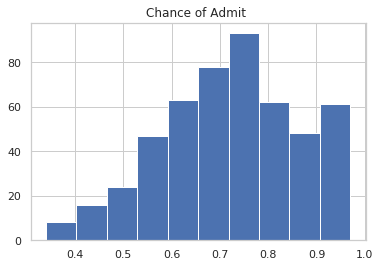

In [7]:
df.hist(column='Chance of Admit ');

In [8]:
df['Chance of Admit '].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit , dtype: float64

Columns are renamed for the sake of simplicity and to allow a more compact representation when shown in plots.  
As anticipated in the introduction, the class label is transformed into a boolean value.

In [9]:
# remove leading and ending spaces in column names
df.columns = df.columns.str.strip()

# rename columns
df = df.rename(columns={'GRE Score': 'GRE', 'TOEFL Score': 'TOEFL', 'Chance of Admit': 'Admitted'})
df.head(5)

# refactor last column: from float to boolean
df['Admitted'] = (df['Admitted'] > 0.75)
df.head(5)

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research,Admitted
0,337,118,4,4.5,4.5,9.65,1,True
1,324,107,4,4.0,4.5,8.87,1,True
2,316,104,3,3.0,3.5,8.00,1,False
3,322,110,3,3.5,2.5,8.67,1,True
4,314,103,2,2.0,3.0,8.21,0,False


Data is already clean since there are neither duplicates nor missing values.

In [10]:
# count duplicates
duplicate_df = df[df.duplicated()]
print('Rows containing duplicates: ', len(duplicate_df))

Rows containing duplicates:  0


In [11]:
# find null/missing values
print('Number of missing values for each attrubute:')
df.isnull().sum()

Number of missing values for each attrubute:


GRE                  0
TOEFL                0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admitted             0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
GRE                  500 non-null int64
TOEFL                500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Admitted             500 non-null bool
dtypes: bool(1), float64(3), int64(4)
memory usage: 27.9 KB


Here some statistics about each attribute is shown:

In [13]:
df.describe()

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000


## Data Esploration <a name="data-esploration"></a>

In this part a preliminary analysis is conducted, aimed at exploring and characterizing the data.
It is an important phase to better design all the subsequent steps, because:
* Quality of data has an impact on the quality of extracted knowledge;
* Understanding the input data allows to make better decisions during training.

,Admitted,Count,Percentage
False,0,290,0.58
True,1,210,0.42


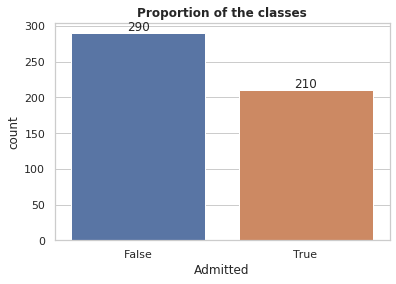

In [14]:
display(pd.DataFrame({'Admitted':['0','1'], 'Count': df['Admitted'].value_counts(), 'Percentage': df['Admitted'].value_counts() / len(df)}))

ax = sns.countplot(x='Admitted', data=df)
plt.title('Proportion of the classes', fontweight="bold")

# add count over rectangles
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='bottom')

Displaying the frequency of the classes is helpful to understand if we are dealing with an imbalanced dataset: the class distribution shows that this is not the case.  
There are more samples with *Admitted* equals to *False*, but not too much. This situation will be addressed when doing the splits, using stratified sampling.

Three types of analysis are performed over the dataset:
* **Univariate analysis**: to describe, summarize and find patterns in the single feature;
* **Bivariate analysis**: to find the relationship between each variable in the dataset and the target variable of interest;
* **Multivariate analysis**: performed to understand interactions between different features.

### Univariate Analysis <a name="univariate-analysis"></a>

**Histogram**

Histograms are used to display the distribution of the attributes: for each value of the feature, the plot shows how many times it appears in the dataset (that is, the frequency of each value). 

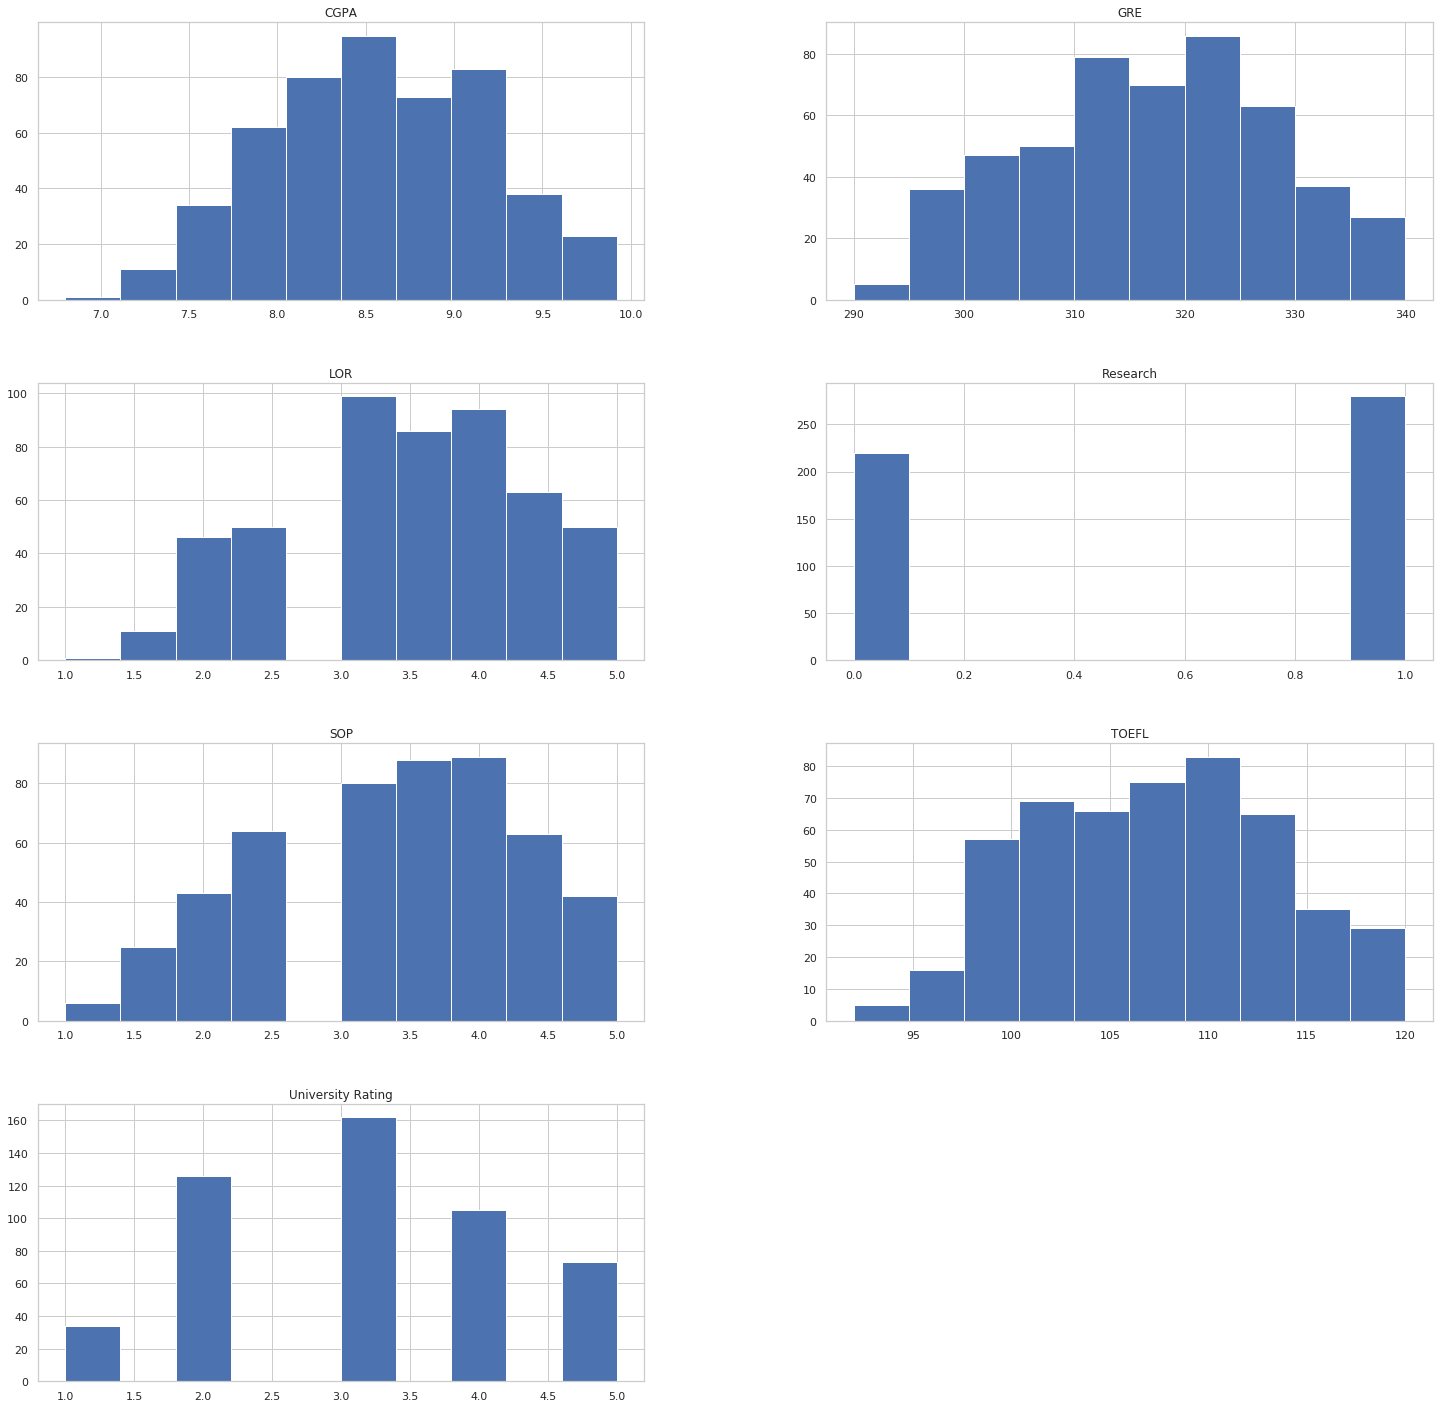

In [15]:
df.drop(columns='Admitted').hist(layout=(4,2), figsize=(25,25));

**Box plot**

Box plots are a convenient way to convey multiple information with a single image. The 5 important values they show are:
* **Median**: middle value of the attribute
* **First quartile (Q1)**: median of the data points to the left of the median
* **Third quartile (Q3)**: median of the data points to the right of the median
* **Minimum value**: min value assumed by the attribute
* **Maximum value**: max value assumed by the attribute  

The interquartile range (**IQR**) goes from Q1 to Q3 and it is a measure of statistical dispersion of data. 

Through this rich visual summary, it is simple to understand if data is symmetrical or skewed and, if so, in what direction.
It also helps visualizing how tightly samples are grouped.

Box plots are also useful to detect **outliers**, that is, extreme values that may be caused by errors in the data or simply be rare events.  
In this concern, it is important to distinguish between extreme values (minimum/maximum) and outliers.  
The calculation of outliers will be performed later.

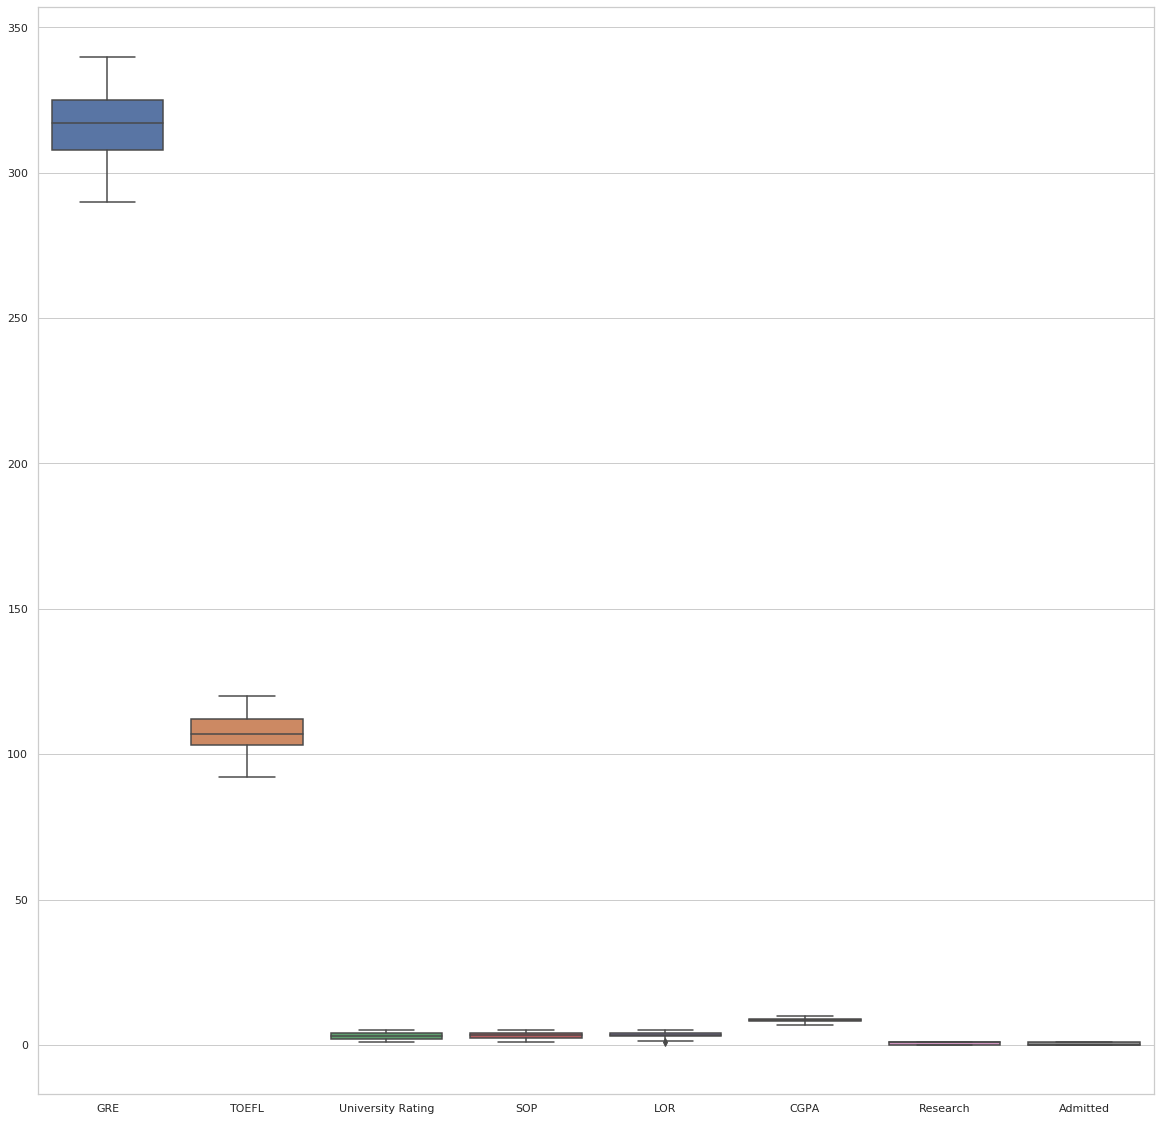

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.boxplot(data=df);

Since attributes belonging to different ranges make it difficult to read, separated box plots are displayed in the next figures:

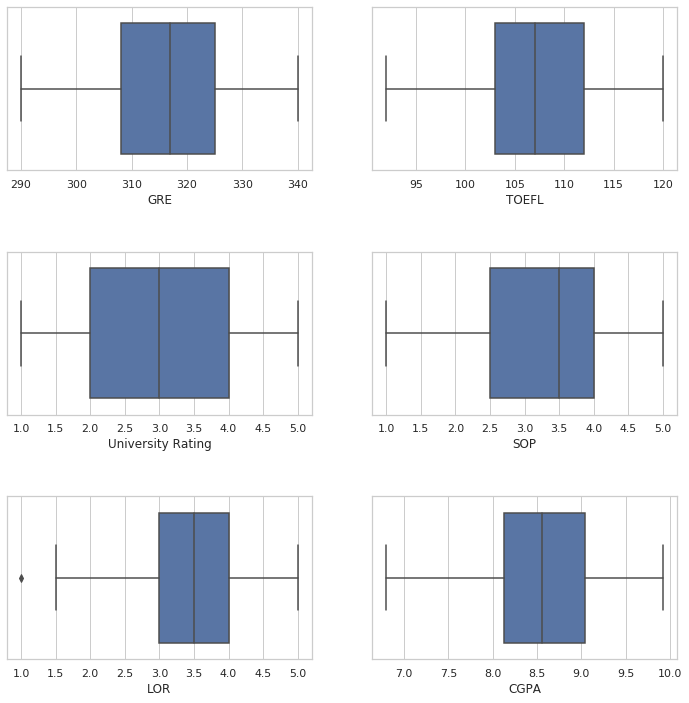

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

for ax, column_name in zip(axes.flatten(), df.columns[:-2]):
    sns.boxplot(x=df[column_name], ax=ax);

The *Research* attribute is not shown, because it is a binary value and its box plot is not meaningful.

In the first image in the last row an outlier can be easily spotted: we try to further investigate and locate the related attributes in the dataset:

In [18]:
# identify the outlier
q1, q3 = np.percentile(df['LOR'], [25, 75])
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound  = q1 - 1.5 * iqr
df[(df['LOR'] < lower_bound) | (df['LOR'] > upper_bound)]

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research,Admitted
347,299,94,1,1.0,1.0,7.34,0,False


The sample detected has a very low value for the *Statement of Purpose* attribute, in fact the corresponding undergraduate is not admitted (also the other features are not quite promising from the point of view of admission chance).  
It does not seem an error in the data, but more likely a possible extreme (negative) case, so we keep it.

### Bivariate Analysis <a name="bivariate-analysis"></a>

Here plots are used again, but this time distinguishing on the label.

**Density plot**

To compare data distributions, histograms are substituted by density plot: the $y$ axis is scaled since values have to sum up to $1$.  
This empirical density estimate is useful to compare it with the theoretical Gaussian pdf.

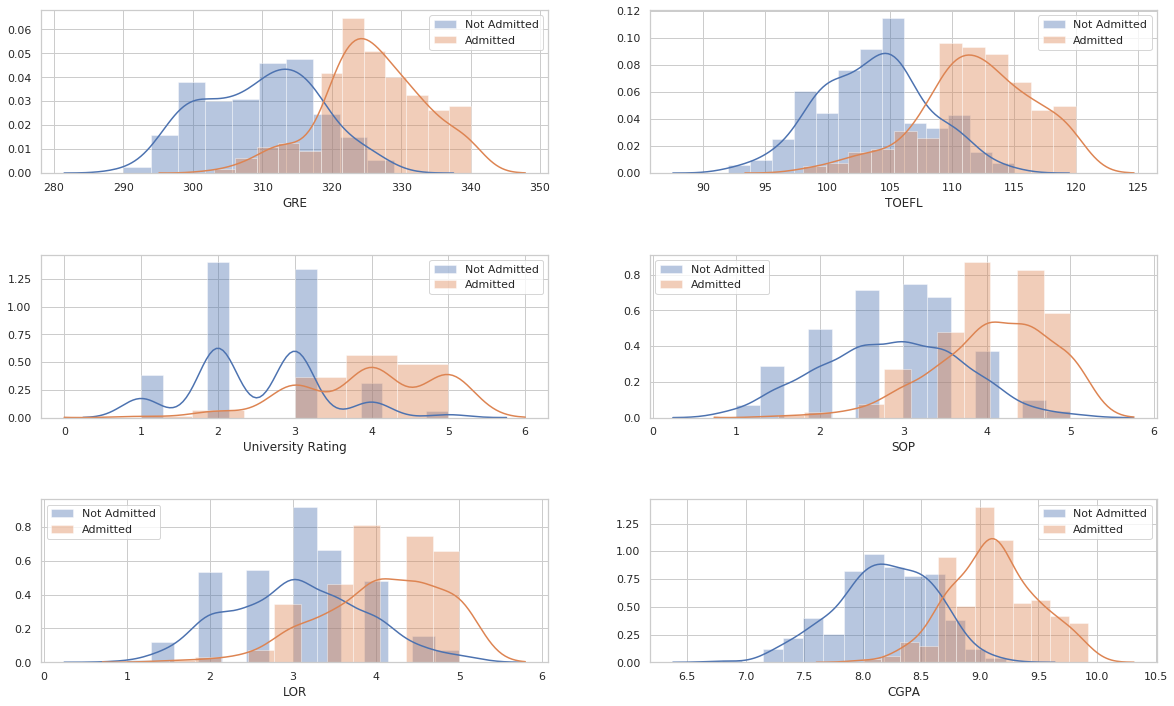

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for ax, column_name in zip(axes.flatten(), df.columns[:-2]):
    curr_column = pd.DataFrame({column_name: df[column_name], 'Admitted': df['Admitted']})
    sns.distplot(df[df['Admitted']==False][column_name], label="Not Admitted", ax=ax)
    sns.distplot(df[df['Admitted']==True][column_name], label="Admitted", ax=ax)
    ax.legend()

Bell curves are not well separated: telling whether an undergraduate will be admitted is a hard task if the decision is based only on one attribute.  
Fortunately, the overlapping is limited to the part close to the tail of the curve. As highlighted in the box plot in the next figure the interquartile ranges are not overlapped.

**Box plot**

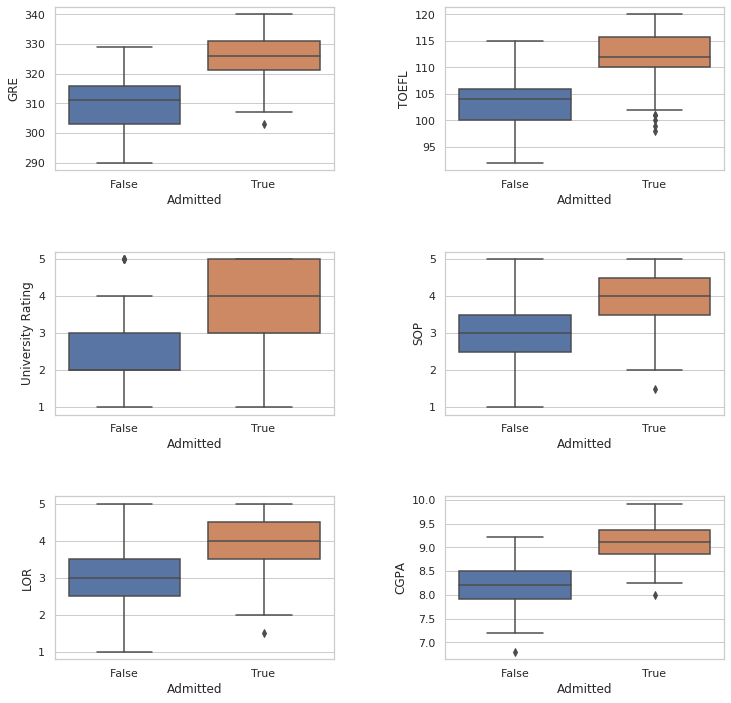

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for ax, column_name in zip(axes.flatten(), df.columns[:-2]):
    sns.boxplot(x='Admitted', y=column_name, data=df, ax=ax)


Outliers can be identified in multiple plots.  
To better understand the data, outliers for *University Rating* and *LOR* attribute are displayed:

In [21]:
df[(df['University Rating'] == 5) & (df['Admitted'] == False)]

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research,Admitted
109,304,103,5,5.0,4.0,8.64,0,False
110,305,108,5,3.0,3.0,8.48,0,False
119,327,104,5,3.0,3.5,8.84,1,False
132,309,105,5,3.5,3.5,8.56,0,False
483,304,103,5,5.0,3.0,7.92,0,False


In [22]:
df[(df['SOP'] < 2) & (df['Admitted'] == True)]

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research,Admitted
441,332,112,1,1.5,3.0,8.66,1,True


In the first case, even if the university is prestigious, other scores are not very high (*TOEF* and *SOP* for example) and there is no research experience, explaining why these students have been rejected.

In the second case the situation is similar: even if the *SOP* is no very good and the university is not high in the rankings, this student has great *GRE* and *TOEFL* scores, hence he is admitted.

### Multivariate Analysis <a name="multivariate-analysis"></a>

**Pair plot**

A grid is created, showing the scatter plot for each couple of attributes, to better highlight the relationship between pairs of features.  
The diagonal axes are treated differently, displaying density plots.

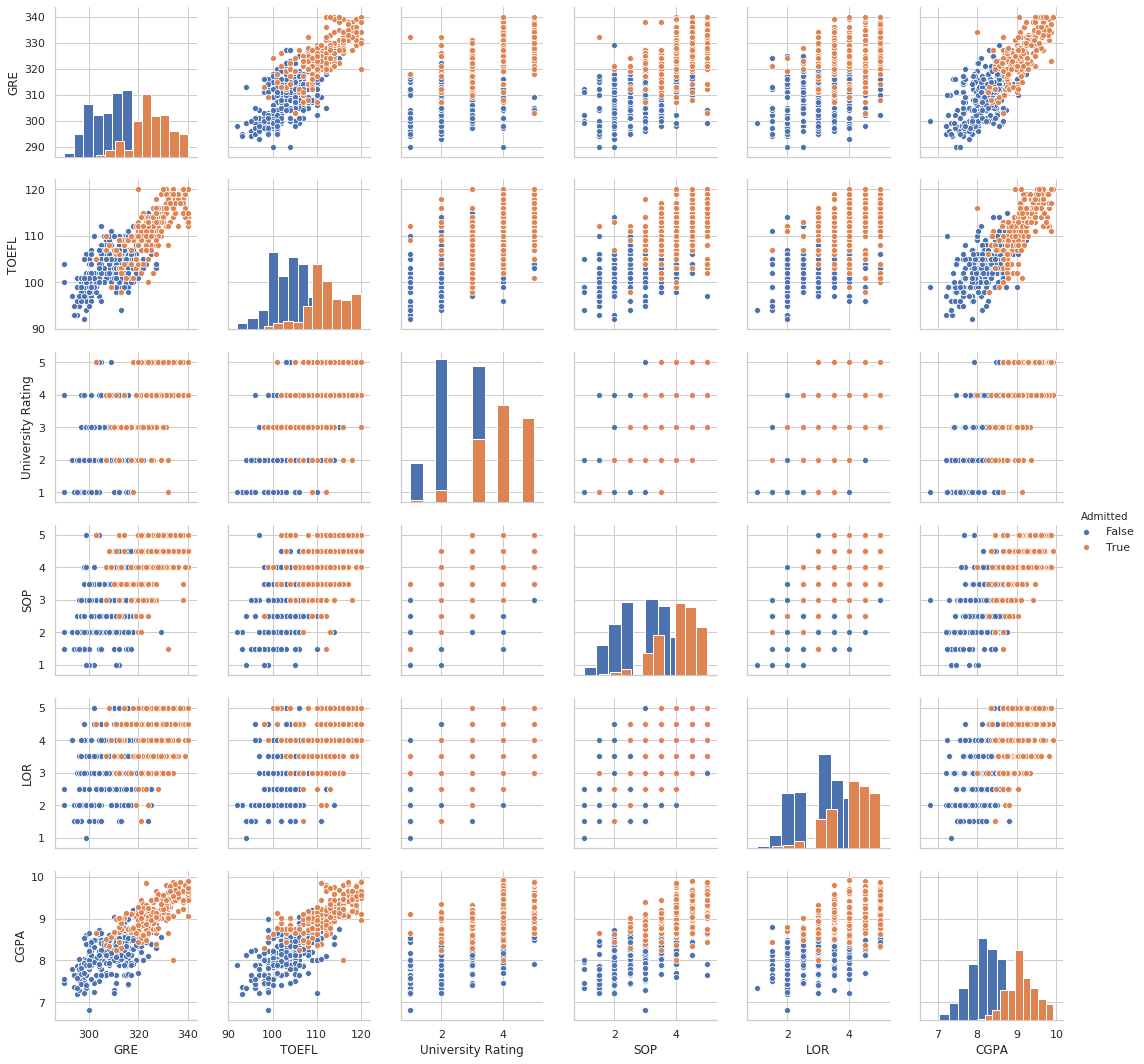

In [23]:
sns.pairplot(df, hue='Admitted', vars=df.columns[:-2], diag_kind='hist');

As expected, *GRE*, *TOEFL* and *CGPA* are positively correlated (as can be seen from the scatter plots), being them similar attributes, all related to scores obtained during tests or classes: if a student has done well in one of them is more likely that he is smart enough to perform well also in the others.   
To have a deeper look in this direction, the correlation matrix is exploited.

**Correlation matrix**

Correlation is a statistic intended to quantify the strength of the relationship between two variables.  
The correlation of two variables can be obtained from the covariance, dividing by the product of the standard deviation of the variables.  
It can range from $-1$ to $+1$. The closer it is to $-1$ or $+1$, the more closely are the two variables are related. The positive sign signifies the direction of the correlation, that is, if one of the variables increases, the other variable is also supposed to increase.

The correlation matrix is a square symmetric matrix with ones on the diagonal (the correlation of an element with itself is $1$).
The results obtained here can be compared with the scatter plots of the previous image.

Highly correlated (correlation > 0.65) attributes with respect to the prediction variable ('Admitted')


GRE      0.706337
TOEFL    0.680069
CGPA     0.760048
Name: Admitted, dtype: float64

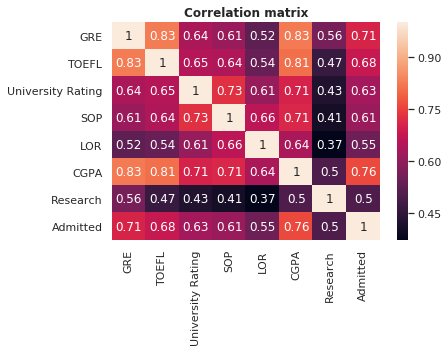

In [24]:
# heat map
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Correlation matrix', fontweight="bold")

# correlation with output variable
print('Highly correlated (correlation > 0.65) attributes with respect to the prediction variable (\'Admitted\')')
cor = df.corr()
cor_target = cor['Admitted']
# selecting highly correlated features
relevant_features = cor_target[cor_target>0.65][:-1] # -1 to remove the label itself
relevant_features

Apart from the correlation between *GRE*, *TOEFL* and *CGPA*, a lower (but still high) one can be found between *SOP* and *University Rating*, maybe because students mention their top-ranked undergraduate university in their cover letter, to make an impression; and best universities provide better services and preparation that can be seen as a strong point by the committee.  
For what concerns the correlation of the features with the label, the three correlated attributes *GRE*, *TOEFL* and *CGPA* are the ones more responsible for the final decision.

## Train/Test Split <a name="split"></a>

The dataset is split into training set (for model building) and test set (for model evaluation) in proportion $7:3$.  
*Stratified sampling* is chosen to ensure that training and test sets have approximately the same percentage of samples for each label.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Admitted'), df['Admitted'].to_frame(), stratify=df['Admitted'], test_size=0.3, random_state=SEED)
print("X_train size:", X_train.shape, "\ny_train size:", y_train.shape)
print("X_test size:", X_test.shape, "\ny_test size:", y_test.shape)
print("\nTraining set:")
display(X_train.head(10))
display(y_train.head(10))
feature_names = X_train.columns

y_train = y_train['Admitted'] # needed to be used in following functions

X_train size: (350, 7) 
y_train size: (350, 1)
X_test size: (150, 7) 
y_test size: (150, 1)

Training set:


,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research
195,307,107,2,3.0,3.5,8.52,1
312,311,107,4,4.5,4.5,9.00,1
104,326,112,3,3.5,3.0,9.05,1
202,340,120,5,4.5,4.5,9.91,1
179,307,102,3,3.0,3.0,8.27,0
178,309,108,3,2.5,3.0,8.12,0
53,324,112,4,4.0,2.5,8.10,1
385,335,117,5,5.0,5.0,9.82,1
250,320,104,3,3.0,2.5,8.57,1
98,332,119,4,5.0,4.5,9.24,1


,Admitted
195,True
312,True
104,False
202,True
179,False
178,False
53,False
385,True
250,False
98,True


## Dimensionality Reduction <a name="dimensionality-reduction"></a>

Feature reduction is usually exploited to speed up training, reduce memory occupation, improve interpretability and especially to avoid the effects of the curse of dimensionality. Even if this is not the case, since the attributes are not too much, it is still applied, to get its other benefits.

Here a brief list of the techniques usually adopted:
* **Feature selection**: uses only a subset of the attributes, the others are discarded;
* **PCA**: is usually used to find the smallest subspace that keeps the most information about the original data, by maximizing the variance (and minimizing the mean squared distance); more details will follow in the next paragraph;
* **LDA**: while PCA yields the directions (principal components) that maximize the variance of the data (ignoring class labels), Linear Discriminant Analysis also aims to find the directions that maximize the separation (or discrimination) between different classes, useful in classification problems; it is a supervised learning technique, as opposed to PCA.

In this study only *PCA* is applied, even if feature selection could also have been used, for example, keeping only one of the attributes among the most correlated ones or keeping only the attributes that are most correlated with the prediction label.  
*LDA* is only shown but not used as input of the classifiers, because of the limitations described later in this notebook.

### PCA <a name="pca"></a>

As mentioned, the unsupervised learning technique called Principal Component Analysis aims at projecting the data into a lower dimensional space while preserving as much information as possible (that is, maximize the variance).

Given a $\mathbf{X}=N\times d$ data matrix, the covariance matrix is computed as
$$\Sigma=\frac{1}{N-1}\mathbf{\bar{X}}^T\mathbf{\bar{X}}$$
where $\mathbf{\bar{X}}$ is obtained by centering $\mathbf{X}$, that is, subtracting from each element of the column vector $\mathbf{x}_i$ of $\mathbf{X}$ the mean, calculated as
$$ \bar{x}_i= \frac{1}{N}\sum_{k=1}^{N} x_{i,k}$$

Now, the PCA basis vectors are the eigenvectors of $\Sigma$.
Among all the eigenvectors, we choose the $k$ eigenvectors with the largest corresponding eigenvalue, that retain most of the information.
These are the top $k$ PCA components, concatenated together to get the projection matrix $W$. The new feature space is obtained through the transformation $X \times W$.

In [26]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
pca = PCA()
pca.fit(X_train)

n_components = len(pca.components_)
pd.DataFrame({'Principal Component': range(1, n_components+ 1),
                'Percentage of variance': pca.explained_variance_ratio_*100,
                 'Cumulative percentage of variance': np.cumsum(pca.explained_variance_ratio_*100)})

,Principal Component,Percentage of variance,Cumulative percentage of variance
0,1,67.401598,67.401598
1,2,10.748744,78.150342
2,3,8.213013,86.363355
3,4,5.194119,91.557474
4,5,3.838347,95.395820
5,6,2.526226,97.922046
6,7,2.077954,100.000000


A useful measure to decide how many principal components to keep for the new feature space is the *explained variance*.  
It tells how much information (variance) can be attributed to each of the principal components, so that the proper number of components can be maintained depending on the target total variance we are willing to reach.

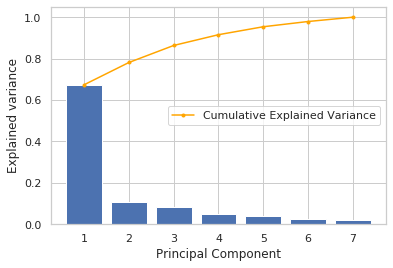

In [28]:
plt.bar(range(1, n_components+ 1), pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Principal Component')
plt.plot(range(1, n_components+ 1), np.cumsum(pca.explained_variance_ratio_),
            c='orange', marker='.', label='Cumulative Explained Variance')
plt.legend();

The first 4 components are kept, to get a total variance of about 90%.  
This is how the new dataset looks like after the transformation:

In [29]:
pca = PCA(n_components=4) # keep about 90% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Features after PCA:')
pd.DataFrame(data=X_train_pca, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4']).head(5)

Features after PCA:


,PC 1,PC 2,PC 3,PC 4
0,0.645548,0.784458,0.788112,-0.528235
1,-1.486765,-0.592821,1.278820,0.275206
2,-1.084770,1.205619,-0.538022,0.014278
3,-4.362403,0.250537,-0.841248,-0.110017
4,1.577193,-0.771383,-0.224053,0.317879


### LDA <a name="lda"></a>

Given the data ${\mathbf{x}_1, \dots, \mathbf{x}_N}$, for each class $i$ we compute the mean vectors $\bar{\mathbf{x}}_i$, that are column vectors containing the mean for each attribute.  

Then the **within-class scatter matrix** $S_W$ is computed as
$$S_W=\sum_{i}^{c}\sum_{j}^{N_i}(\mathbf{x}_{i,j}-\bar{\mathbf{x}}_i)(\mathbf{x}_{i,j}-\bar{\mathbf{x}}_i)^T$$
The **between-class scatter matrix** $S_B$ is computed as
$$S_B=\sum_{i}^{c}N_i(\bar{\mathbf{x}}_i-\bar{\mathbf{x}})(\bar{\mathbf{x}}_i-\bar{\mathbf{x}})^T$$
where $\bar{\mathbf{x}}$ is the overall mean, $c$ is the total number of classes, $N_i$ is the size of class $i$.

Now, as in PCA, for the matrix ${S_W}^{-1}S_B$ we keep the eigenvectors corresponding to the $k$ greatest eigenvalues, obtaining the matrix $\mathbf{W}$, then multiplied by the input matrix $\mathbf{X}$ to get the final transformed matrix.

*LDA* is not used (but only discussed) in this homework because of the *scikit-learn* library limitation: in case of binary classification it allows to generate only one component, provoking too much loss of information.  
However, the principal component of LDA is obtained and plotted in the next figure: as expected the principal component separates well the two classes. 

In [30]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
pd.DataFrame(data=X_train_lda, columns=['PC 1']).head(5)

,PC 1
0,-0.283675
1,1.073405
2,1.182190
3,3.465961
4,-1.091756


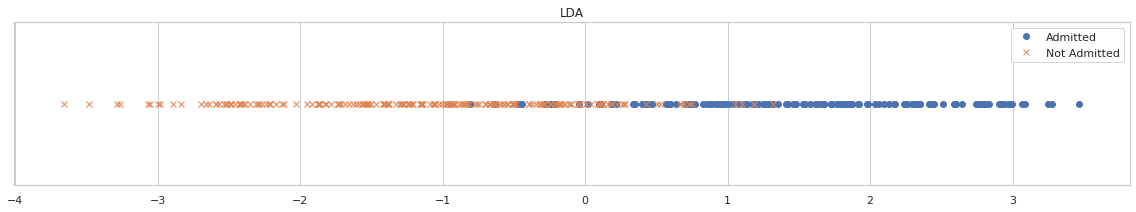

In [31]:
plt.figure(figsize=(20,3))
plt.plot(X_train_lda[y_train == True], np.zeros(len(X_train_lda[y_train == True])), 'o', label="Admitted")
plt.plot(X_train_lda[y_train == False], np.zeros(len(X_train_lda[y_train == False])), 'x', label="Not Admitted")
plt.yticks([])
plt.title("LDA")
plt.legend();

## Model Training <a name="model-training"></a>

For model evaluation there exist several partition techniques:
* **Holdout**: fixed partitioning in train and validation sets; less accurate than other methods, but the only one appropriate for large datasets;
* **Cross validation** (or k-fold validation): first partition the dataset into $k$ disjoint subsets (that is, folds), then train on $k-1$ partitions and test on the remaining one; repeating this method for each partition provides a reliable accuracy estimation, at the expense of a slower training;
* **Leave-one-out**: variation on cross validation, each fold contains only one record. It is only feasible with small datasets.

After this step, the classifier is built on both train and validation sets, using the best parameters learned from the previous step.

In [32]:
accuracy = []
precision = []
recall = []
f1 = []
models = []

In [33]:
def print_grid_search_results(curr_model_params, grid_search):
    print('Complete list of results (best ones are highlighted):')
    params = []
    for mean_test, param in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
        row = []
        for value in curr_model_params:
            row.append(param[value])
        row.append(mean_test)
        params.append(row)
    column_names = list(curr_model_params.keys())
    column_names.append('mean_test_score')

    grid = pd.DataFrame(params, columns=column_names)
    max_value = grid['mean_test_score'].max()
    display(grid.style.apply(lambda x: ['background: yellow' if x.mean_test_score == max_value else '' for i in x], axis=1))

    print(f"Best parameters: {grid_search.best_params_}\nScore: {grid_search.best_score_}")

In this case study cross validation is used with $k=5$.

### Logistic Regression <a name="logistic-regression"></a>

**Algorithm description**

In linear regression, given the the input vector $x$ and the regression coefficients $w_0, w_1, ... ,w_p$, we can make predictions using the formula
$$\hat{y} = w_0 + w_1x_1 + w_2x_2 + ... + w_px_p$$
That can be written in vector form as
$$\hat{y} = \boldsymbol{w}^T\boldsymbol{x}$$
The parameters $w_0, w_1, ..., w_p$ are 
chosen to minimize the residual sum of squares
$$RSS = \sum_{i=1}^{n} (y_i-\hat{y}_i)^2$$

Instead, when dealing with logistic regression, we want our output to be between 0 and 1, to be interpreted as a probability.  
For this reason we plug the previous result into the sigmoid function
$$g(z) = \frac{1}{1 + e^{-z}}$$
obtaining
$$\hat{y} = \frac{1}{1+e^{-\boldsymbol{w}^T\boldsymbol{x}}} = P(Y=0 \vert x)$$
where the last equality is an assumption.

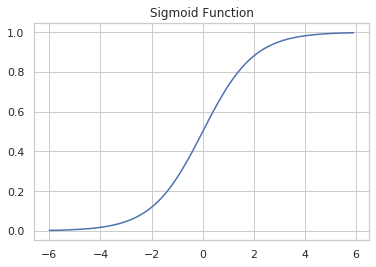

In [34]:
# display sigmoid function
x = np.arange(-6, 6, 0.1)
sig = [1 / (1 + np.exp(-i)) for i in x]
plt.plot(x,sig)
plt.title('Sigmoid Function');

We cannot use the same cost function as in linear regression, because it will lead to a non-convex function, difficult to optimize (using gradient descent).
This time the optimization problem can be expressed in terms of the *likelihood function*

$$\mathcal{L}(W) = \prod_{l} P(Y^l \vert X^l,W)$$

that is the probability of predicting the right output (with $l$ equals to the number of samples). Separating $Y^l=0$ and $Y^l=1$ and taking the logarithm  we obtain the *log-likelihood*

$$\ell(W) = \sum_{l} Y^lln{P(Y^l=1|X^l,W) + (1-Y^l)ln{P(Y^l=0|X^l,W)}}$$

$$= \sum_{l} Y^l(w_0+\sum_{i}^{n}w_iX_i^l) - ln(1+exp(w_0+\sum_{i}^{n}w_iX_i^l))$$
where $n$ is the number of attributes, that is what we want to maximize.  
Fortunately, it is a concave function (with a unique maximum) and has to be solved using gradient ascent, since no close form solution can be obtained.

Then we usually add the regularization by subtracting from $\mathcal{L}(W)$ the quantity

$$R = \frac{\alpha}{2} \|w\|_2^2 = \frac{\alpha}{2} \sum_{i}^{n} w_i^2$$

In this case we are using L2 regularization, but there exist other forms of regularization (e.g. L1).
Other than the type of regularization, another hyper-parameter of logistic regression is $\alpha$, to control the regularization itself. 


**Model tuning**

Parameters to tune:
* **penalty**: the kind of regularization to use (as described in the previous paragraph); can be ```l1``` or ```l2```;
* **C**: it is equal to $\frac{1}{\alpha}$; the higher $\alpha$ the lower the coefficients $\boldsymbol{w}$ will be, leading to a simpler model. 
A correct tuning of $\alpha$ may help to prevent overfitting. If it is too high underfitting may arise.

In [35]:
reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
reg = LogisticRegression(solver = 'liblinear', random_state=SEED)
gs = GridSearchCV(reg, reg_params, cv=5)
gs.fit(X_train_pca, y_train)
print_grid_search_results(reg_params, gs)

# store best model
models.append(gs.best_estimator_)

Complete list of results (best ones are highlighted):


,penalty,C,mean_test_score
0,l1,0.001,0.58
1,l2,0.001,0.88
2,l1,0.01,0.871429
3,l2,0.01,0.868571
4,l1,0.1,0.862857
5,l2,0.1,0.871429
6,l1,1,0.871429
7,l2,1,0.874286
8,l1,10,0.874286
9,l2,10,0.874286


Best parameters: {'C': 0.001, 'penalty': 'l2'}
Score: 0.8800000000000001


**Summary**

Logistic Regression is not one of the most powerful classifier, but it has the advantage of being simple and efficient.  
It is usually a good starting point to then move to more complex algorithms.  
Being an easy model, it provides a good interpretation: it is possible to understand which are the most important features by looking at the ones with higher weights.

### KNN <a name="knn"></a>

**Algorithm description**

K-Nearest Neighbor classifier starts from the assumption that close/similar samples belong to the same class.

In more detail, given:
* training samples $\{x_i,y_i\}$, where $x_i$ is the attribute of the sample, $y_i$ is the class label
* testing point $x$ (without labels) that we want to classify

The algorithm proceeds as follows:
* compute the distance $d(x,x_i)$ to every training example $x_i$
* select the $k$ closest instances and their labels
* output the class $\hat{y}$ which is the most frequent among the $k$ selected

**Model tuning**

Parameters to tune for this model:
* **number of neighbors**: the most critical value, a small ```k``` makes the model sensitive to outliers, a large one consider too many samples (also distant/non-similar records) during prediction;
* **distance metric $p$**: defines the distance metric to use, ```p=1``` stands for L1 norm (Manhattan distance) while ```p=2``` means L2 norm (Euclidean distance);
* **weights**: if ```uniform``` is set, the final decision is taken upon majority vote (for this reason an odd number of k must be used); if ```distance``` is selected the contribution of the neighbors is weighted by the inverse of their distance.

In [36]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7, 11, 17, 25],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, knn_params, cv=5)
gs.fit(X_train_pca, y_train)
print_grid_search_results(knn_params, gs)

# store best model
models.append(gs.best_estimator_)

Complete list of results (best ones are highlighted):


,n_neighbors,p,weights,mean_test_score
0,1,1,uniform,0.822857
1,1,1,distance,0.822857
2,1,2,uniform,0.822857
3,1,2,distance,0.822857
4,3,1,uniform,0.842857
5,3,1,distance,0.84
6,3,2,uniform,0.831429
7,3,2,distance,0.822857
8,5,1,uniform,0.845714
9,5,1,distance,0.828571


Best parameters: {'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}
Score: 0.8857142857142858


**Summary**

KNN main advantages are that it is simple, easy to train (no training at all) and that it is able to obtain non-linear boundaries.  
On the other side, it is sensible to outliers (this can be handled by using a proper $k$ value) and it is computationally expensive at test time (for each test sample, need to iterate over all the dataset to calculate the distance).


### SVM <a name="svm"></a>

**Algorithm description**

The main idea behind Support Vector Machines is trying to find a plane that separates the classes in feature space.
In particular, among all separating hyperplanes, we want to find the one that makes the biggest gap or margin between the two classes.

In this Large Margin Classifier formulation, the problem can be expressed as a constraint optimization problem:

$$\max_{w,b}M$$

$$\text{ subject to } y_i[\langle x_i,w \rangle +b]\geq 1$$
with $M$ being the margin

If it is not possible to linearly separate the two classes, two alternatives are available:
1. Use soft margins, allowing some samples to be on the wrong side of the linear separator
2. Enlarge the feature space (with kernels) so that separation is possible

1. Allowing soft margins and adding slack variables, the problem becomes:
$$\max_{w,b}M+C\sum_{i}\xi_i$$
$$\text{ subject to } y_i[\langle x_i,w \rangle +b]\geq 1 -\xi_i and \xi_i \geq 0$$

2. The kernel trick, that projects the input space in a high-dimensional feature space, consists in substituting $\langle x_i,x_j \rangle$ in the resolution of the optimization problem with $k(x_i,x_j)$,

*Notes*:  
The margin can be expressed as $\frac{2}{\| w \|}$.  
Usually, instead of a maximization problem, minimizing $\frac{1}{2}\| w \|^2$ is preferred.

**Model tuning**

Parameters to tune:
* **regularization parameter $C$**: represents the trade-off between smoothness and correctness.  
With a large $C$, more train points are classified correctly and the resulting margin is smaller.  
With a small $C$, the boundary is smoother and the models generalize better (less prone to overfit); in this case the margin is larger.  
If $C = 0$ a hard-margin classifier is obtained, not allowing samples to be misclassified;
* **gamma $\gamma$**: parameter of the Gaussian/RBF (radial basis function) kernel; a high value of gamma can lead to overfitting.


In [37]:
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 1, 10, 100]
}
svm = SVC(kernel='rbf', random_state=SEED)
gs = GridSearchCV(svm, svm_params, cv=5)
gs.fit(X_train_pca, y_train)
print_grid_search_results(svm_params, gs)

# store best model
models.append(gs.best_estimator_)

Complete list of results (best ones are highlighted):


,C,gamma,mean_test_score
0,0.01,0.01,0.58
1,0.01,0.1,0.58
2,0.01,1,0.58
3,0.01,10,0.58
4,0.01,100,0.58
5,0.1,0.01,0.871429
6,0.1,0.1,0.877143
7,0.1,1,0.845714
8,0.1,10,0.58
9,0.1,100,0.58


Best parameters: {'C': 1, 'gamma': 1}
Score: 0.8828571428571428


**Summary**

SVMs try to learn from the most challenging points to separate (support vectors).  
Because they are affected only by points near to the margin, they work well with high-dimensional data, even data with more dimensions than samples (which is a challenging regime for other algorithms).  
Unfortunately, results do not have a direct interpretation.

SVMs are generally chosen when other simpler, faster, and less tuning-intensive methods have been shown to be insufficient, since their training can be quite expensive.

### Decision Tree <a name="decision-tree"></a>

**Algorithm description**

A decision tree is a tree structure in which each internal node represents a condition on an attribute to test in order to predict the output.  
Data is split at each internal node and each leaf node makes a prediction.  
To perform a prediction the tree is traversed starting from the root until a leaf node is reached. 

Since it is infeasible to consider every possible partition of the feature space to choose the best partition, a top down, *greedy approach* is used: the best attribute for the split is selected locally at each step (no global optimum).

A key point in constructing the tree is selecting the best attribute to use for the split at each node. For this reason two different measures of node impurity are usually used:
* **Gini index**: it is a measure of how often a randomly chosen element from the set would be incorrectly labelled. A small value indicates that a node contains predominantly observations from a single class.  
The Gini at a certain node $n$ can be calculated by summing up for each class $j$ the square of the relative frequency $p$
$$I_G(n) = 1 - \sum_{j} p_j^2$$
* **Entropy**: the intuition is the same as before, but in this case logarithms are used for convenience
$$I_H(n) = -\sum_{j} p_j log_2(p_j)$$

Once the impurity values are calculated for the nodes resulting after a split, the overall impurity of the split *s* can be obtained by summing the *Gini* of the nodes, weighted by their frequencies:
$$I_G(s) = \sum_{i=1}^{k} \frac{n_i}{n}I_G(i)$$
where $k$ is the number of the partition, $n_i$ the number of records at node $i$ and $n$ the number of records at the parent node.

For the split, the attribute with the smallest *Gini* is selected, as it produces less impurity in the output.  
Similar formulas exist to compute the split impurity using *Entropy*.

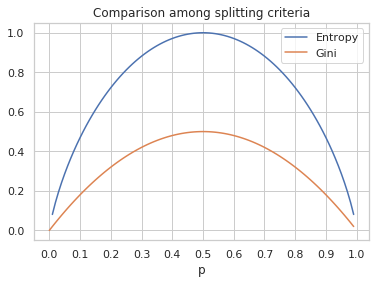

In [38]:
# plot gini and entropy
p = np.arange(0, 1, 0.01)
plt.plot(p, -p * np.log2(p) - (1 - p) * np.log2(1 - p), label="Entropy"); # -p*log(p) - (1-p)*log(1-p)
plt.plot(p, -2*p*(p - 1), label="Gini") # 1 - p^2 - (1-p)^2

plt.xlabel("p")
plt.title('Comparison among splitting criteria');
plt.legend();
plt.xticks(np.arange(0, 1.1, 0.1));


In the figure above the representation of Gini and entropy for a 2-class problem.  
Gini's maximum impurity is 0.5, while entropy's maximum impurity is 1.

**Model tuning**

Parameters to tune:
* **criterion**: the splitting criterion to use, Gini index or Entropy;
* **max depth**: the maximum height of the tree, it is used as stopping criterion to avoid overfitting;
* **min impurity decrease**: tells to add new nodes in depth only if impurity decreases above the specified threshold; again, it is a condition used to prevent the tree from becoming a fully-grown tree and lose generalization.

In [39]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 10] , # maximum tree height
    'min_impurity_decrease': [1e-4, 1e-3, 1e-2, 1e-1] # split nodes only if impurity decrease above threshold
}
dt = DecisionTreeClassifier(random_state=SEED)
gs = GridSearchCV(dt, dt_params, cv=5)
gs.fit(X_train_pca, y_train)
print_grid_search_results(dt_params, gs)

# store best model
models.append(gs.best_estimator_)

Complete list of results (best ones are highlighted):


,criterion,max_depth,min_impurity_decrease,mean_test_score
0,gini,1,0.0001,0.86
1,gini,1,0.001,0.86
2,gini,1,0.01,0.86
3,gini,1,0.1,0.86
4,gini,3,0.0001,0.845714
5,gini,3,0.001,0.845714
6,gini,3,0.01,0.845714
7,gini,3,0.1,0.86
8,gini,5,0.0001,0.842857
9,gini,5,0.001,0.845714


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_impurity_decrease': 0.0001}
Score: 0.8714285714285716


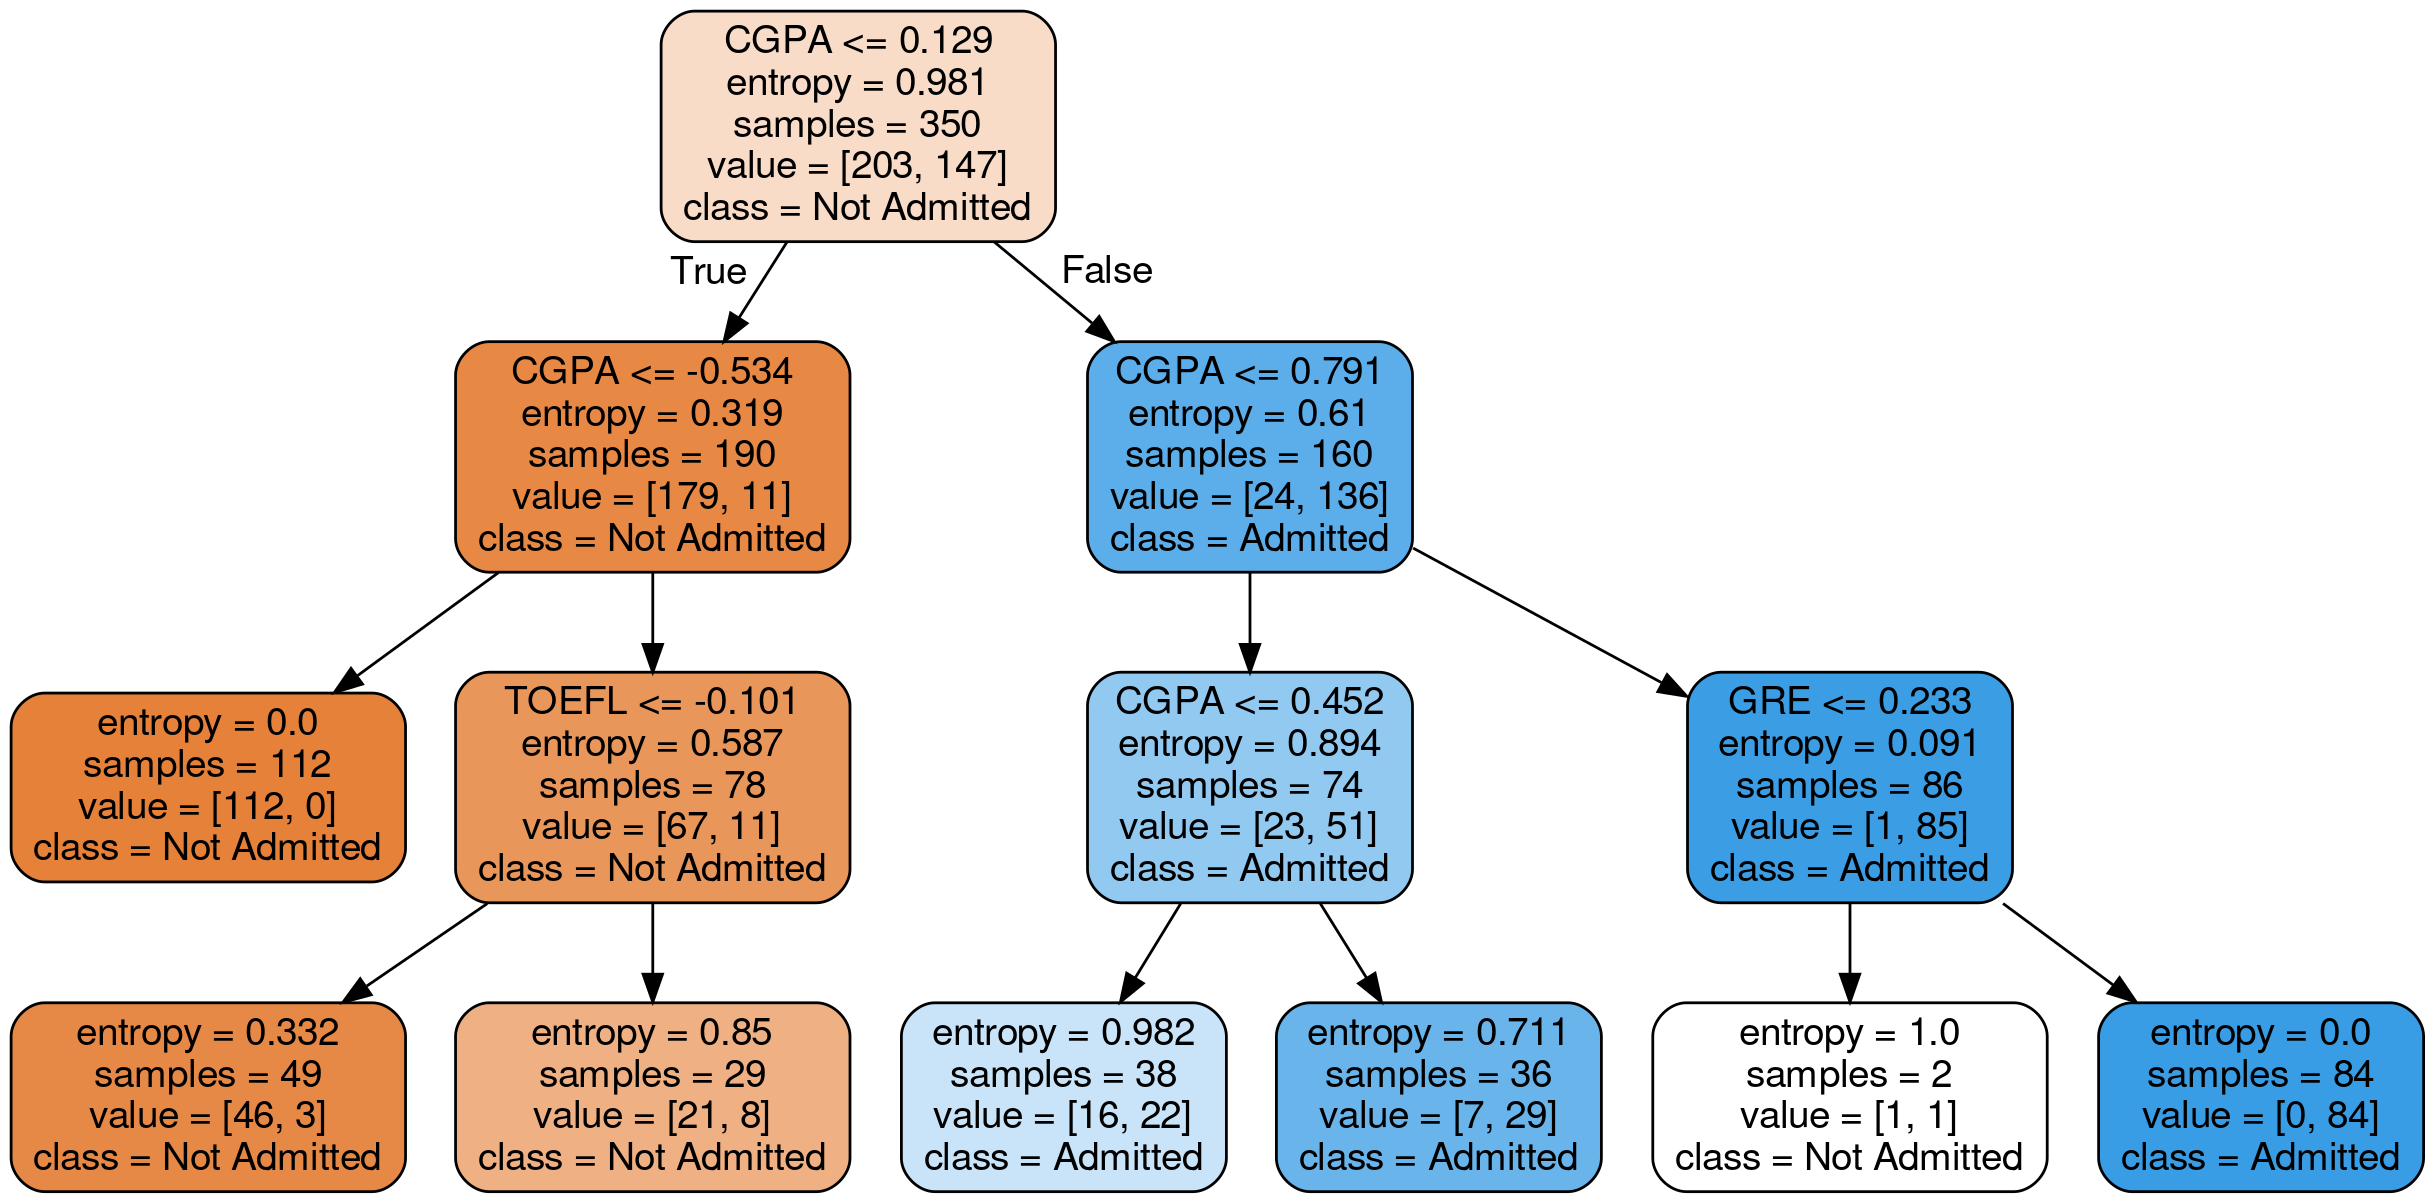

In [40]:
# not using PCA for interpretability purposes
tree = clone(gs.best_estimator_)
tree = tree.fit(X_train, y_train)
export_graphviz(tree, out_file='tree.dot', 
                feature_names=feature_names,
                class_names = ['Not Admitted', 'Admitted'],
                rounded = True, filled = True)

!dot -Tpng tree.dot -o tree_resized.png -Gdpi=200
Image(filename = 'tree_resized.png')

Once the tree structure in the previous image is built, making predictions is only a matter of traversing the tree until a leaf node is reached: the class of that leaf represents the label predicted.

Being on the top of the tree, CGPA reveals to be the most discriminative attribute for the algorithm.
In general, features on the top are the most important ones because they are the main responsible for the final output. This makes the model easy to interpret.

**Summary**

The main advantage of decision trees is that they are simple and useful for interpretation.  
On the other hand, their performance in terms of prediction accuracy is not competitive with other classification algorithms.

Techniques as random forests and boosting are used to combine multiple tree to yield better accuracy at the expense of some loss of interpretation.

### Random Forest <a name="random-forest"></a>

**Algorithm description**

Random forests are part of the so called *ensamble techniques*, that combine together different models in order to improve accuracy and stability over a single model.

While in boosting the models are applied in sequence, with random forest a set of decision trees is trained independently and the final outcome is obtained by means of majority vote.

In details, given a training set $D$ of $n$ instances, $B$ decision trees are trained, each one using $n'\leq n$ random samples taken from $D$ with replacement.  
For each split in the learning process a random subset of $\sqrt{p}$ features is selected among the total $p$ features of the initial training set $D$. 

This ensures that the trees are decorrelated, hence different features could be selected as best attribute for the split.

**Model tuning**

Parameters to tune (many are the same of decision trees):
* **n_estimators**: the number of trees in the forest, key parameter for the algorithm;
* **criterion**
* **max depth**
* **min impurity decrease**

In [41]:
%%time
rf_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 10],
    'min_impurity_decrease': [1e-4, 1e-3, 1e-2, 1e-1],
    'n_estimators': [10, 20, 50, 80, 100]
}
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
gs = GridSearchCV(rf, rf_params, cv=5)
gs.fit(X_train_pca, y_train)
print_grid_search_results(rf_params, gs)

# store best model
models.append(gs.best_estimator_)

Complete list of results (best ones are highlighted):


,criterion,max_depth,min_impurity_decrease,n_estimators,mean_test_score
0,gini,1,0.0001,10,0.868571
1,gini,1,0.0001,20,0.871429
2,gini,1,0.0001,50,0.874286
3,gini,1,0.0001,80,0.874286
4,gini,1,0.0001,100,0.874286
5,gini,1,0.001,10,0.868571
6,gini,1,0.001,20,0.871429
7,gini,1,0.001,50,0.874286
8,gini,1,0.001,80,0.874286
9,gini,1,0.001,100,0.874286


Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.01, 'n_estimators': 10}
Score: 0.8828571428571429
CPU times: user 1min 56s, sys: 4.33 s, total: 2min 1s
Wall time: 5min 20s


**Summary**

This method reduces variance and overfitting, while, by contrast, individual decision trees typically exhibit high variance and tend to overfit.  
All these benefits at the cost of losing some interpretability and a longer training speed (about 5 minutes in this analysis, very slow with respect to previous models).

## Model Evaluation <a name="model-evaluation"></a>

To reliably estimate the performance of the models produced, different measures are calculated and plots are visualized, to simplify the comparison between the classifiers.

### Learning Curve <a name="learning-curve"></a>

The learning curve shows how accuracy changes in train and validation for varying sample sizes.
It is a tool to detect bias/variance errors, where high bias means underfitting and high variance stands for overfitting.

In a learning curve, the performance of a model both on the training and validation set is plotted as a function of the training set size.
High training score and low validation score at the same time indicates that the model has overfit the data, that is, has adapted too well to the specific training set samples. As the training set increases, overfitting decreases, and the validation score increases.

In general, the training accuracy goes down because it is easy to fit a model with few samples (e.g. a line passing through two points), but it will not generalize well on validation data. With increasing dataset size, it is going to be harder to fit the training data, but it is more likely that the generalization gets better.

From these curves, it can be understood how much getting more data is going to help building a better classifier.

In [42]:
model_names = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest']

In [43]:
def plot_learning_curve(estimator, X, y, ax, title, cv=7):
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, random_state=SEED)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()

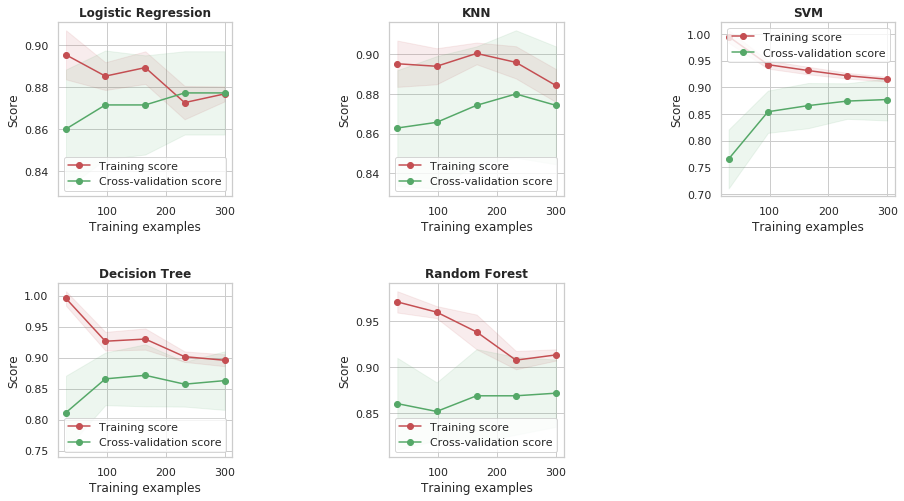

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
fig.subplots_adjust(wspace=0.9, hspace=0.5)
fig.delaxes(axes[1][2])

for i, model in zip(range(len(models)), models):
    ax = axes.ravel()[i]
    plot_learning_curve(model, X_train_pca, y_train, ax, model_names[i])

**Decision Tree**: the model works well already with few samples; with about $300$ samples, training and validation curves seem to get closer, as expected from a learning curve plot; the final accuracy is not very high.  
**SVM**: the initial accuracy on the validation set is low, but then, with enough samples, the curves approach and tend to a high accuracy value.  
**Random Forest**: some amount of overfitting is present, since the two curves are far from each other also with many samples.  
**Logistic Regression**: after an overlapping at about $200$ samples, the scores converge.  
**KNN**: similarly to the other plots, the curves get close, after an increase of the training accuracy in between $100$ and $200$ samples.

*Caveat*: As noted during various experiments, when using the *distance* metric in *KNN* the training curve shows an accuracy of $1$ for any number of training samples. The reason is that, using the *distance* metric, close points have a high weight; but if we use the training set for both train and test phases, of course for each tested point there will be the same element in the train set, with a distance equal to 0, hence maximum weight. This high weight will dominate the final decision producing a plot with a constant training accuracy of $1$.

### Confusion Matrix <a name="confusion-matrix"></a>

Confusion matrices, used in binary classification, show True/False positives and True/False negatives, helping to measure the type of error the model is making when classifying the observations into different classes.

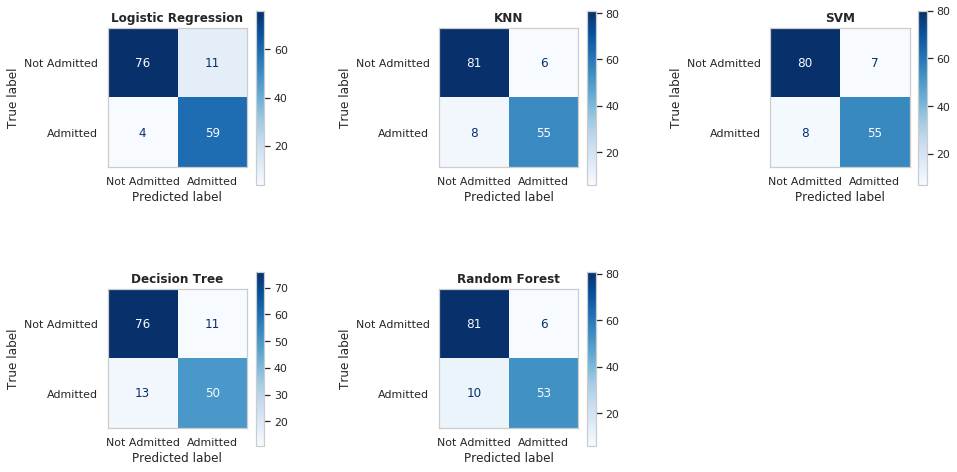

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
fig.subplots_adjust(wspace=0.9, hspace=0.5)
fig.delaxes(axes[1][2])

for i, model in zip(range(len(models)), models):
    ax = axes.ravel()[i]
    metrics.plot_confusion_matrix(model, X_test_pca, y_test, display_labels=['Not Admitted', 'Admitted'], cmap=plt.cm.Blues, ax=ax)
    ax.grid(False) # hide grid
    ax.set_title(model_names[i], fontweight="bold");

In this case, the positive class is *Admitted*.  
The matrix structure is:

|  TN  |  FP  |
|------|------|
|**FN**|**TP**|

reported since it is different from the standard visualization, with *True Positives* in the top left corner. 

*KNN* is the most capable of reducing the number of False Positives (as shown by the *Precision* measure in the next paragraph, calculated considering the second column of the matrix).  
The *Logistic Regression* model limits the amount of False Negatives (as shown by the *Recall* measure in the next paragraph, calculated considering the second row of the matrix).

### Performance Measures<a name="performance-measures"></a>

From the confusion matrix, 4 metrics can be defined:
* **Accuracy**: tells how often the classifier is correct; not always a reliable metric (e.g. in case of unbalanced class label distribution or different class relevance);
$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$
* **Precision**: tells how often the classifier is correct when it predict yes; it is used when we want to limit the number of false positives $FP$;
$$p = \frac{TP}{TP+FP}$$
* **Recall**: tells, when it is actually the positive result, how often it predicts correctly;
$$r = \frac{TP}{TP+FN}$$
* **F1-score**: harmonic mean of precision and recall, used to combine the two metrics.
$$F_1 = \frac{2pr}{p+r}$$

In [46]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for model in models:
    y_pred = model.predict(X_test_pca)
    accuracy_list.append(metrics.accuracy_score(y_test, y_pred))
    precision_list.append(metrics.precision_score(y_test, y_pred))
    recall_list.append(metrics.recall_score(y_test, y_pred))
    f1_list.append(metrics.f1_score(y_test, y_pred))
    auc_list.append(metrics.roc_auc_score(y_test, y_pred))
display(pd.DataFrame({'Accuracy': accuracy_list, 'Precision': precision_list, 'Recall': recall_list, 'F1 Score': f1_list}, index=model_names))

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.900000,0.842857,0.936508,0.887218
KNN,0.906667,0.901639,0.873016,0.887097
SVM,0.900000,0.887097,0.873016,0.880000
Decision Tree,0.840000,0.819672,0.793651,0.806452
Random Forest,0.893333,0.898305,0.841270,0.868852


Apart from the *Decision Tree* model, the results of all the classifiers are really close.  
*Logistic Regression* is the best models from the point of view of *F1 Score*, while *KNN* gets the best accuracy.

### ROC Curve <a name="roc-curve"></a>

The Receiver Operating Characteristic curve plots the True Positive Rate on the $x$ axis and the False Positive Rate on the $y$ axis.
$$TPR=\frac{TP}{TP+FN}, FPR=\frac{FP}{FP+TN}$$

The plot is generated by changing a threshold in the model (if the model predicts a probability, the threshold can be the minimum value accepted to predict a positive outcome).  
ROC curve characterizes the trade-off between positive hits and false alarms: a low $FPR$ is usually obtained at the expense of a low $TPR$.  
A good model is able to get a good (high) $TPR$ even with a small $FPR$.

The point $(0,1)$ represents a model in which all the samples declared positive are in fact positive.
The position $(0,0)$ is obtained from a model that always predict *False*, while in $(1,1)$ everything is predicted as positive, since both $TPR$ and $FPR$ are equal to $1$. 

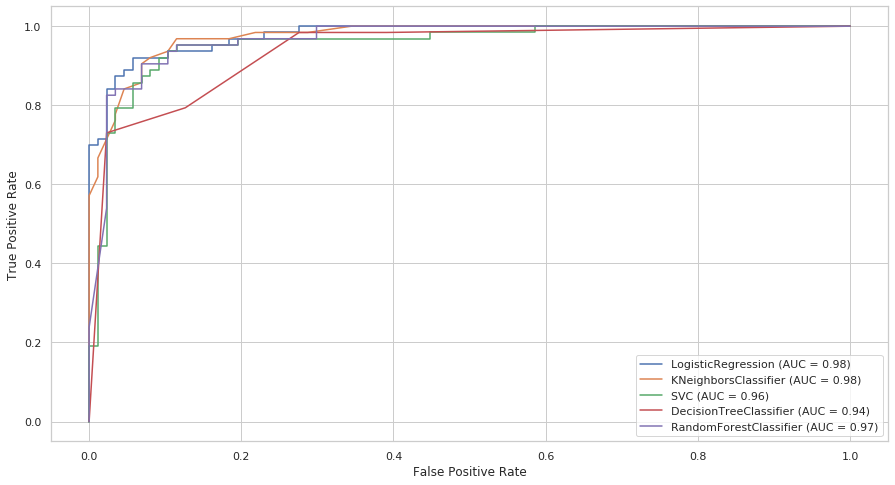

In [47]:
fig, ax = plt.subplots(figsize=(15,8))

for model in models:
    disp = metrics.plot_roc_curve(model, X_test_pca, y_test, ax=ax)

Some models can be better for small $FPR$ and others for large $FPR$: to discriminate between these models the $AUC$ (Area Under ROC curve) metric is used (in the figure above): the bigger the area under the curve the better the model performs.  
An area equal to $1$ is the ideal and maximum possible score, $0.5$ means random guessing and $0$ is the worst case: the model always predicts the wrong class.

In this case, as can be observed in the bottom right corner of the previous image, *Logistic Regression* and *KNN* yield the best result, but the other classifiers are quite close.

## Conclusion <a name="conclusion"></a>

In this case study, techniques for data exploration, models for classification and evaluation methods were explored.  
The produced classifiers predict the admission or rejection to a graduate program: in a real life scenario, the model is useful from the perspective of a student who want to know what are the odds of being accepted, or from the perspective of the committee, to get support in decisions.

*Logistic Regression*, *KNN* and *SVM* are the most promising classifiers, producing a high accuracy in a short amount of time (with respect to *Random Forest*). Depending on the constraints of the system one among them can be chosen: in particular *Logistic Regression* could be a good fit, since it is not expensive at evaluation time with respect to *KNN* and it is easier and more interpretable than *SVM*.
The final accuracy is not very high, also because the amount of data is limited in amount: a bigger dataset could have produced better results.

Finally, this work has been a great opportunity to get hands-on experience with the more common instruments and techniques used in machine learning and to apply the knowledge acquired during the course.